In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm


sns.set_style('darkgrid')
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12,10)})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline
pd.set_option('display.max_rows',2000)

%run ../shared_datasets/charlie_functions.py
%run ../shared_datasets/clean_dataframe.py

First, we load our raw data from a local CSV. We then clean it and add features according to specifications in the 'clean_dataframe.py' file. 

In [6]:
raw_data = pd.read_csv('/Users/schlinkertc/Flatiron/projects/mod4_project/developer_survey_2019/survey_results_public.csv')

dataframe_class = CleanDataframe(raw_data)
df = dataframe_class.cleaned_df

Let's take a look at the underlying distribution of 'ConvertedComp', our dependent variable.

- The ConvertedComp field in our raw data is erratic with may outliers
- We limit our scope to below 500,000 and 250,000, respectively

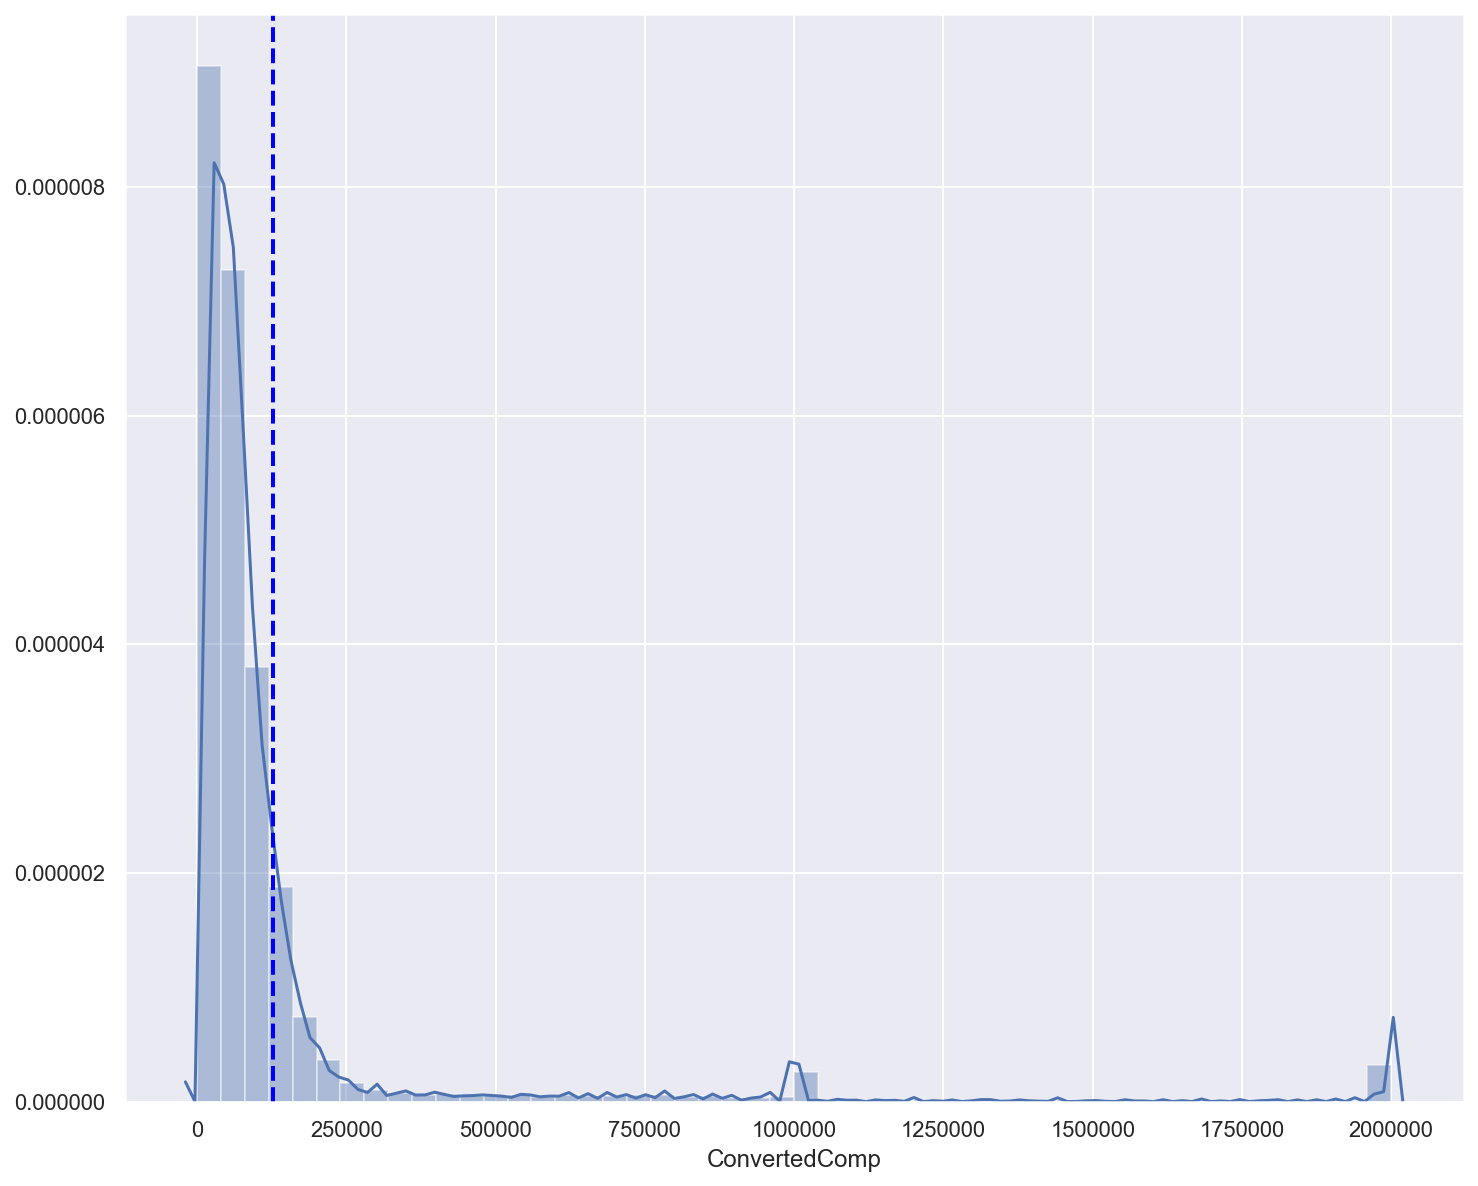

In [8]:
sns.set(rc={'figure.figsize':(12,10)})

sns.distplot(raw_data['ConvertedComp'].dropna())
plt.axvline(raw_data['ConvertedComp'].mean(),color='blue', linestyle='--', lw=2)

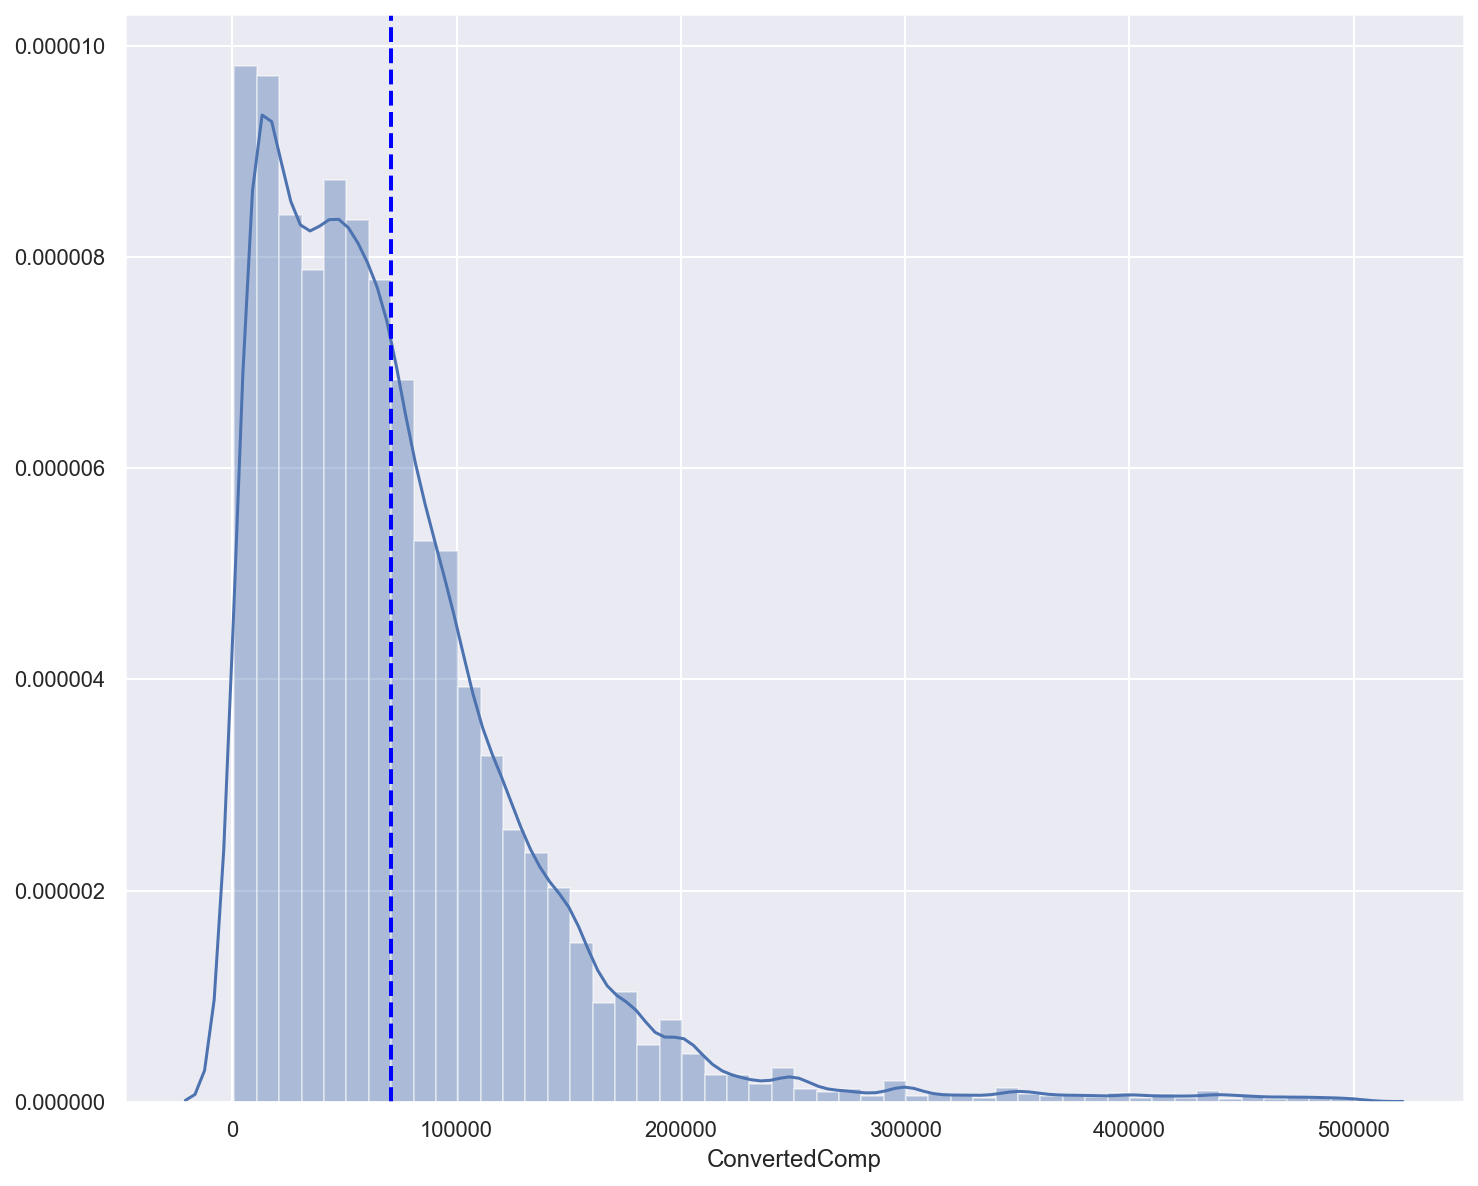

In [9]:
sns.distplot(df['ConvertedComp'])
plt.axvline(df['ConvertedComp'].mean(),color='blue', linestyle='--', lw=2)

In [13]:
df = df[(df['ConvertedComp']>10000) & (df['ConvertedComp']<250000)]

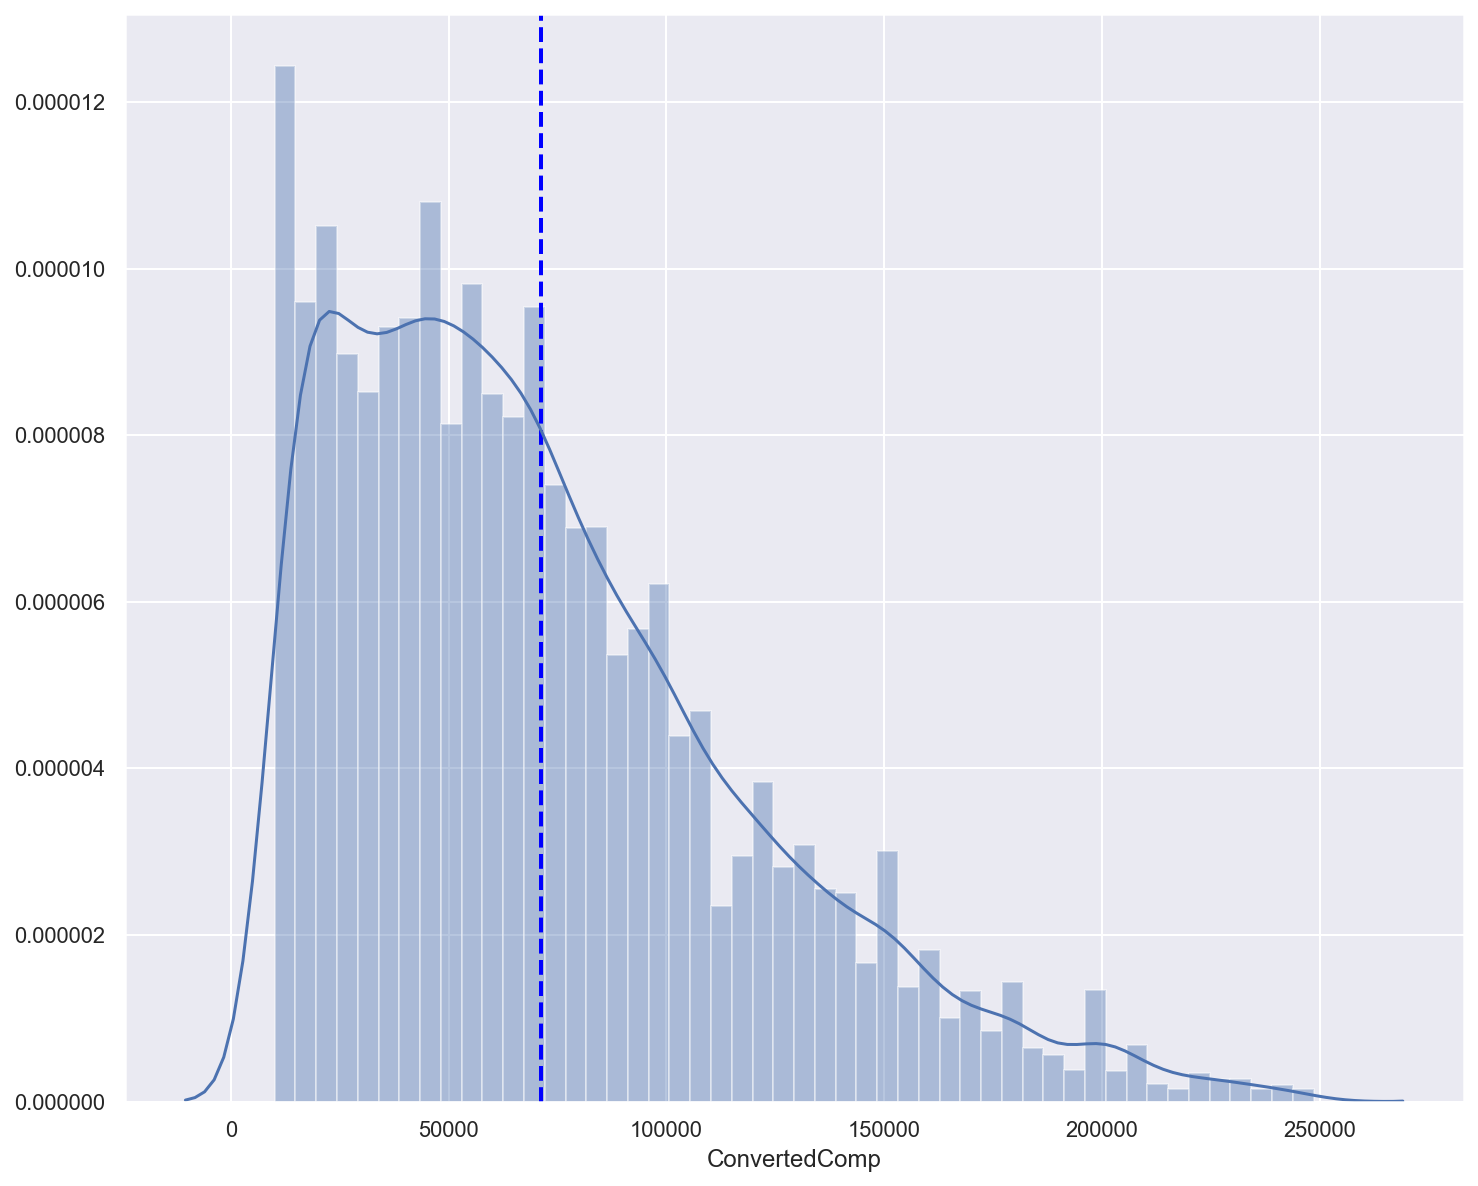

In [14]:
sns.set(rc={'figure.figsize':(12,10)})
plt.axvline(df['ConvertedComp'].mean(),color='blue', linestyle='--', lw=2)

sns.distplot(df['ConvertedComp'])

## Regression using OLS

After setting our X and Y variables, we're ready to being our linear regression. The sm_OLS fucntion, defined in 'charlie_functions.py', uses statsmodels.api.LinearRegression() 

- First we solve for the ordinary least squares regression and return performance metrics, coefficient values, and predicted vs observed outcomes.
- Next, the recursive ols function will run the regression, elimnate any coeffecients with a p-value above .05, and run the regression again. 
    - This will repeat until all coefficients have an an acceptable p-value.

In [17]:
# set X and Y
X = df.drop(columns=['Respondent','ConvertedComp'])
Y = df['ConvertedComp']

sm_performance,sm_variables,sm_outcomes = sm_OLS(X,Y)

In [18]:
# make a deep copy of our X values for the recursive function
X_recursive = pd.DataFrame.copy(X,deep=True)

In [21]:
recursive_performance,recursive_variables,recursive_outcomes = ols_recursion(X_recursive,Y)

predictors used:  294
Predictors to drop:  139
Running regression with new subset of predictors...
predictors used:  155
Predictors to drop:  28
Running regression with new subset of predictors...
predictors used:  127
Predictors to drop:  6
Running regression with new subset of predictors...
predictors used:  121
Predictors to drop:  3
Running regression with new subset of predictors...
predictors used:  118
Predictors to drop:  0
Complete. No coefficients with P-value greater than .05 remain


By eliminating predictors with p-values above .05 recursively, we've cut our number of variables down from 294 to 118. Eliminating these variables had very little effect on our regression performance. 

In [33]:
comparison = pd.concat((sm_performance.transpose(),recursive_performance.transpose()),ignore_index=True)
comparison.index = ['294 predictors','118 predictors']
comparison

,MSE,MSE_resid,RMSE,R^2,R^2_adjusted,F-stat,AIC,BIC
294 predictors,1.004529e+11,7.988160e+08,28263.333964,0.634374,0.629329,125.752237,434101.460873,436090.390822
118 predictors,2.186926e+11,8.071898e+08,28411.085172,0.627761,0.625444,270.930785,434158.717270,435067.047483


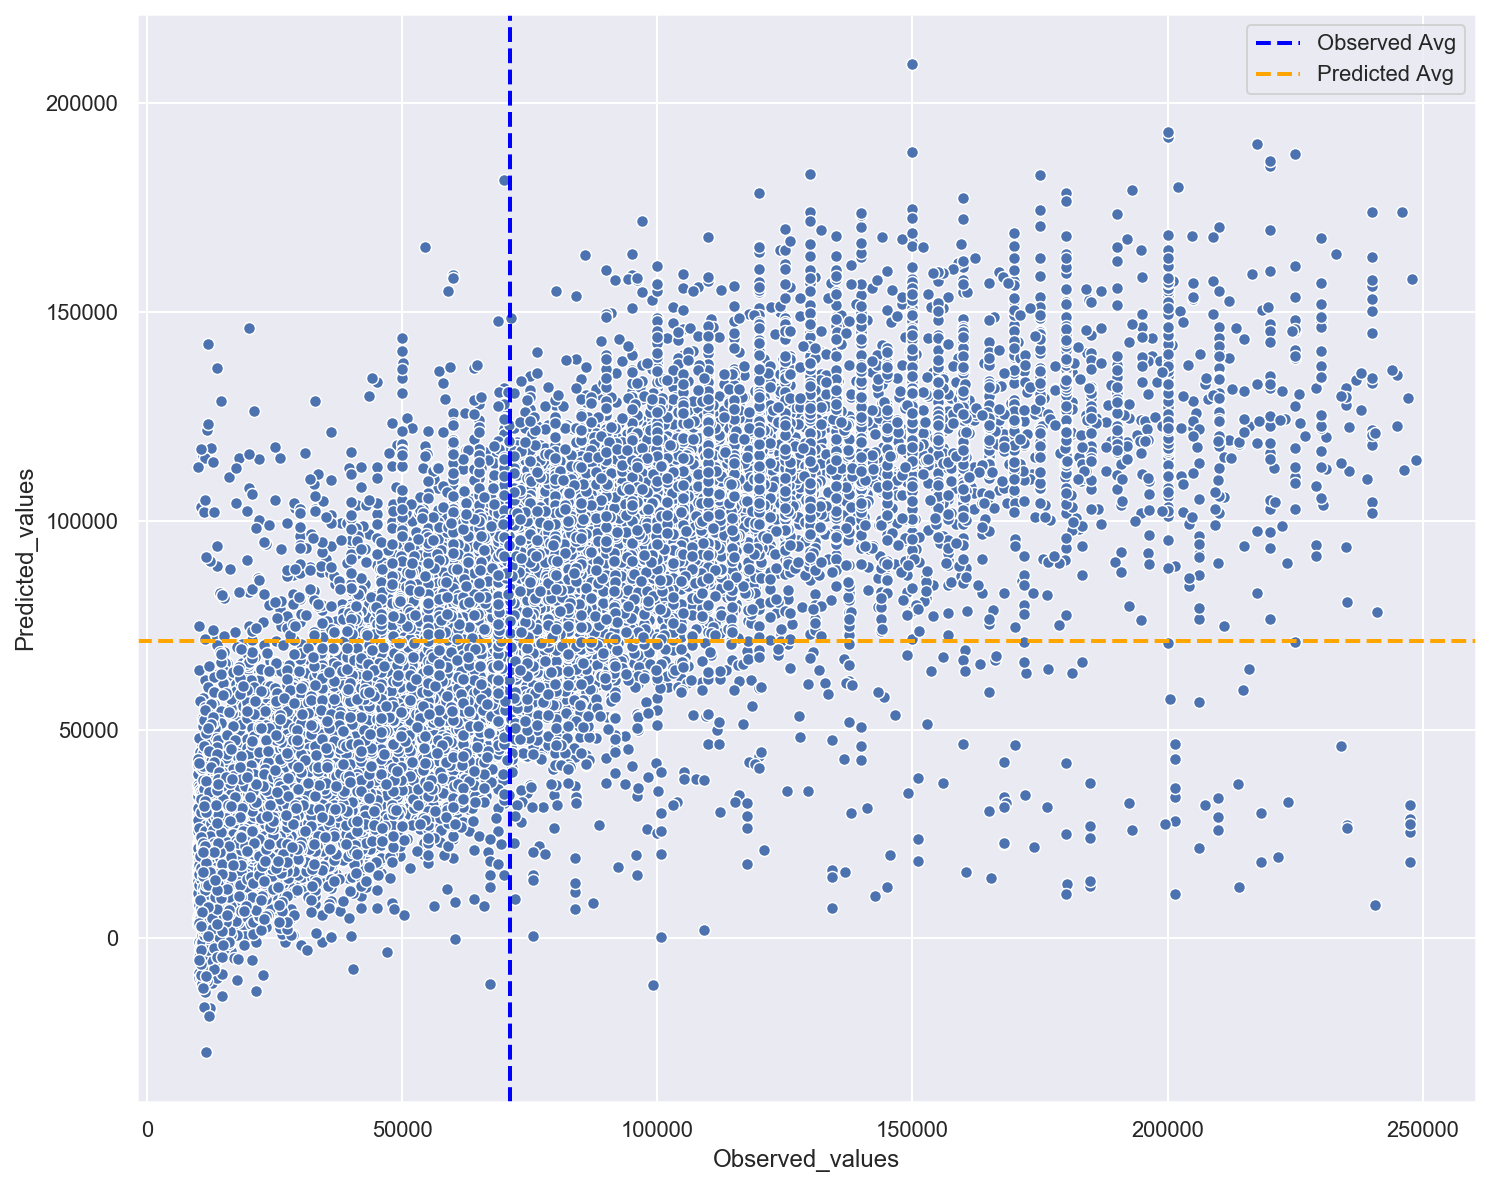

In [36]:
sns.scatterplot(x=recursive_outcomes['Observed_values'],y=recursive_outcomes['Predicted_values'])
plt.axvline(recursive_outcomes['Observed_values'].mean(),color='blue', linestyle='--', lw=2,label='Observed Avg')
plt.axhline(recursive_outcomes['Predicted_values'].mean(),color='orange', linestyle='--', lw=2,label='Predicted Avg')
plt.legend()


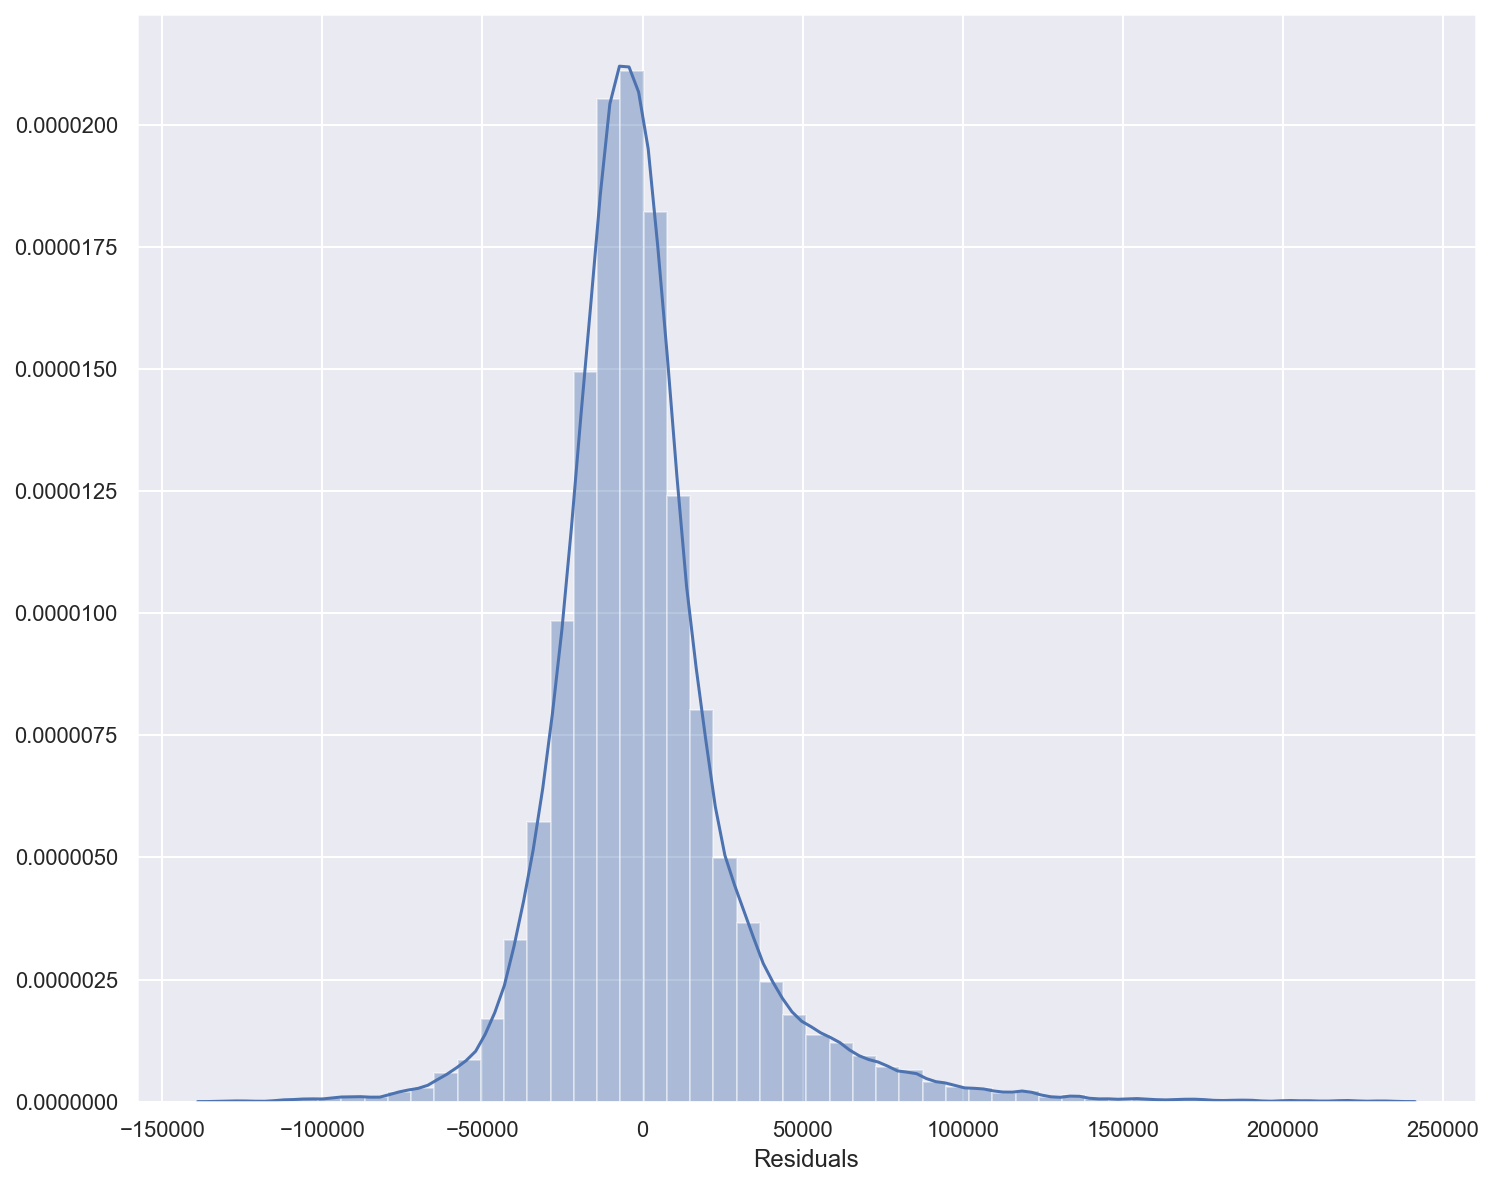

In [41]:
# Check residuals for normality
sns.distplot(recursive_outcomes['Residuals'])

## Log transform our Y-variable

According to University of Virginia: 
- "Log transformations are often recommended for skewed data, such as monetary measures or certain biological and demographic measures. Log transforming data usually has the effect of spreading out clumps of data and bringing together spread-out data." 

- We can't log-transform our predictors because we have dummy variables

- rules for interpretation when the outcome is transformed: 
    - Exponentiate the coefficient, subtract one from this number, and multiply by 100. This gives the percent increase (or decrease) in the response for every one-unit increase in the independent variable. Example: the coefficient is 0.198. (exp(0.198) – 1) * 100 = 21.9. For every one-unit increase in the independent variable, our dependent variable increases by about 22%.

In [58]:
log_performance, log_variables, log_outcomes = sm_OLS(X_recursive,np.log(Y))

In [62]:
log_performance = log_performance.transpose()
log_performance.index=['118 predictors, log transformed']

In [64]:
comparison.append(log_performance)

,MSE,MSE_resid,RMSE,R^2,R^2_adjusted,F-stat,AIC,BIC
294 predictors,1.004529e+11,7.988160e+08,28263.333964,0.634374,0.629329,125.752237,434101.460873,436090.390822
118 predictors,2.186926e+11,8.071898e+08,28411.085172,0.627761,0.625444,270.930785,434158.717270,435067.047483
"118 predictors, log transformed",6.006396e+01,1.576250e-01,0.397020,0.703434,0.701588,381.055945,18527.063999,19435.394212


## To Recap:

We ran a regression with 294 predictors. Then, we got rid of any predictors that had unacceptably high p-values. We did so recursively. Eliminating those variables decreased our R^2 very slightly. Finally, we log-transformed our outcome variable, and our R^2 went up to 70%. Now, we're going to attempt to train a model using cross-validation and regularization.  

### Regularization and Cross-Validation

In [69]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

This function splits the data into training and test sets for cross validation. In addition to X and Y values, it takes in the name of the model to use and the alpha value. It returns the predictor coefficients and the training/test R^2

In [75]:
def regularization(x_values,y_values,alpha_val,Model):
    scale = MinMaxScaler()
    transformed = scale.fit_transform(x_values)
    
    X_transformed = pd.DataFrame(transformed, columns = x_values.columns)
    
    X_train , X_test, y_train, y_test = train_test_split(X_transformed, y_values, test_size=0.2, random_state=12)
    
    if Model == LinearRegression:
        #OLS doesn't use an alpha
        model = Model()
    else:
        model = Model(alpha=alpha_val)
        
    model.fit(X_train, y_train)    
    
    variables = pd.DataFrame(model.coef_,index=x_values.columns,columns=['Coefficients'])
    intercept = pd.DataFrame.from_dict({'Intercept':model.intercept_},orient='index',columns=['Coefficients'])
    
    
    performance = {'Train':model.score(X_train,y_train),'Test':model.score(X_test,y_test)}
    
    return variables.append(intercept),performance
    

In [76]:
#we'll use this function to test different Alpha values 
optimal_alphas = {}
def optimal_alpha(start,stop,steps,Model,chart_title,x_values,y_values):
    test_R_squared = []
    alpha = []
    for i in np.linspace(start,stop,num=steps):
        #print('Alpha: ',i,'Test R^2: ',regularization(Xtemp,Ytemp,i,Lasso)[1]['Test'],sep='\n')
        alpha.append(i)
        test_R_squared.append(regularization(x_values,y_values,i,Model)[1]['Test'])
    sns.lineplot(alpha,test_R_squared)
    plt.xlabel('Alpha')
    plt.ylabel('Test R^2')
    plt.title('{} Regression: Test R^2 for Increasing Alpha Value'.format(chart_title))
    plt.axhline(max(test_R_squared),linestyle='--',label='Alpha: {},R^2: {}'.format(alpha[test_R_squared.index(max(test_R_squared))],max(test_R_squared)))
    plt.legend()
    
    optimal_alphas[chart_title]=alpha[test_R_squared.index(max(test_R_squared))]
    

### Lasso 

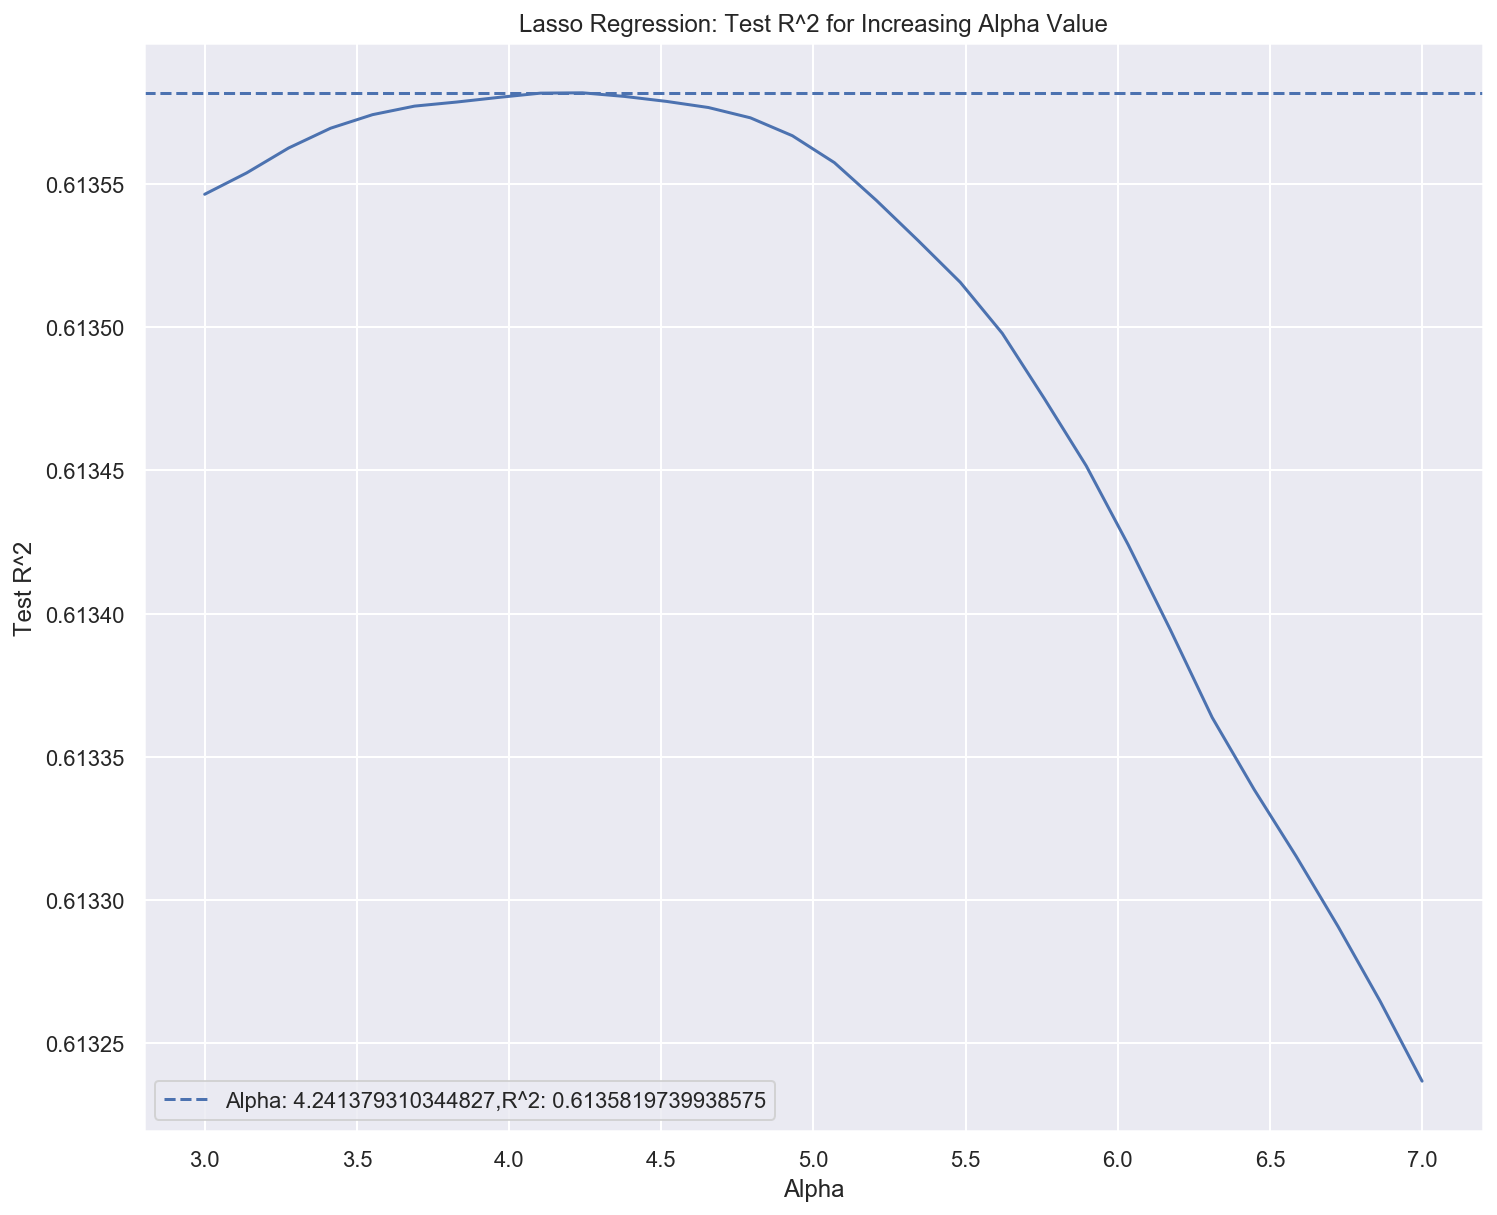

In [77]:
optimal_alpha(3,7,30,Lasso,'Lasso',X,Y)

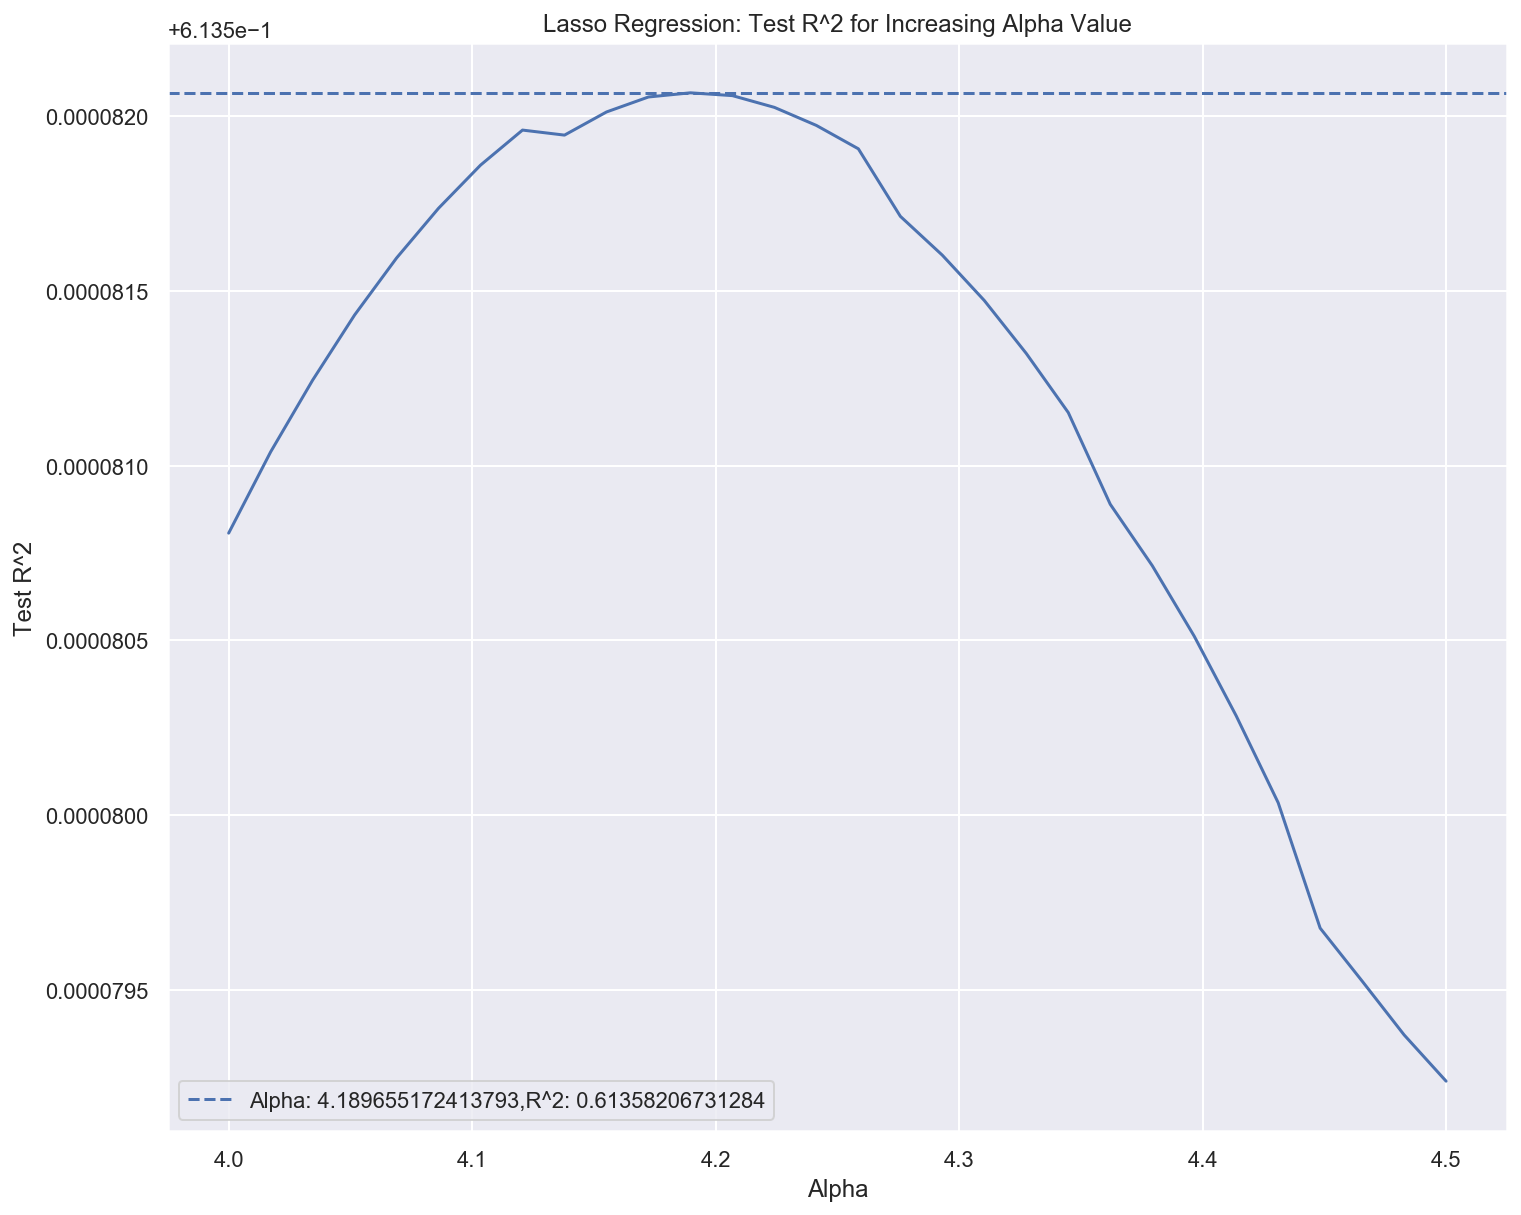

In [89]:
optimal_alpha(4,4.5,30,Lasso,'Lasso',X,Y)

In [90]:
optimal_alphas

{'Lasso': 4.189655172413793, 'Lasso_subset': 0.0}

In [91]:
# run the lasso regression using the optimal alpha value that we found.
lasso_variables,lasso_performance = regularization(X,Y,optimal_alphas['Lasso'],Lasso)

In [92]:
# R^2 values for training and test data
lasso_performance

{'Train': 0.6367560473338405, 'Test': 0.61358206731284}

In [93]:
# variables that the Lasso regression discarded 
lasso_removed = lasso_variables[lasso_variables['Coefficients']==0].index.tolist()
len(lasso_removed)

80

What happens if we run a lasso regression using the subset of 118 predictors?


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5941431668883.078, tolerance: 3214765315.335133
  positive)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12638768007.978516, tolerance: 3214765315.335133
  positive)
//anaconda3/lib/python3.7/site-packages/sk

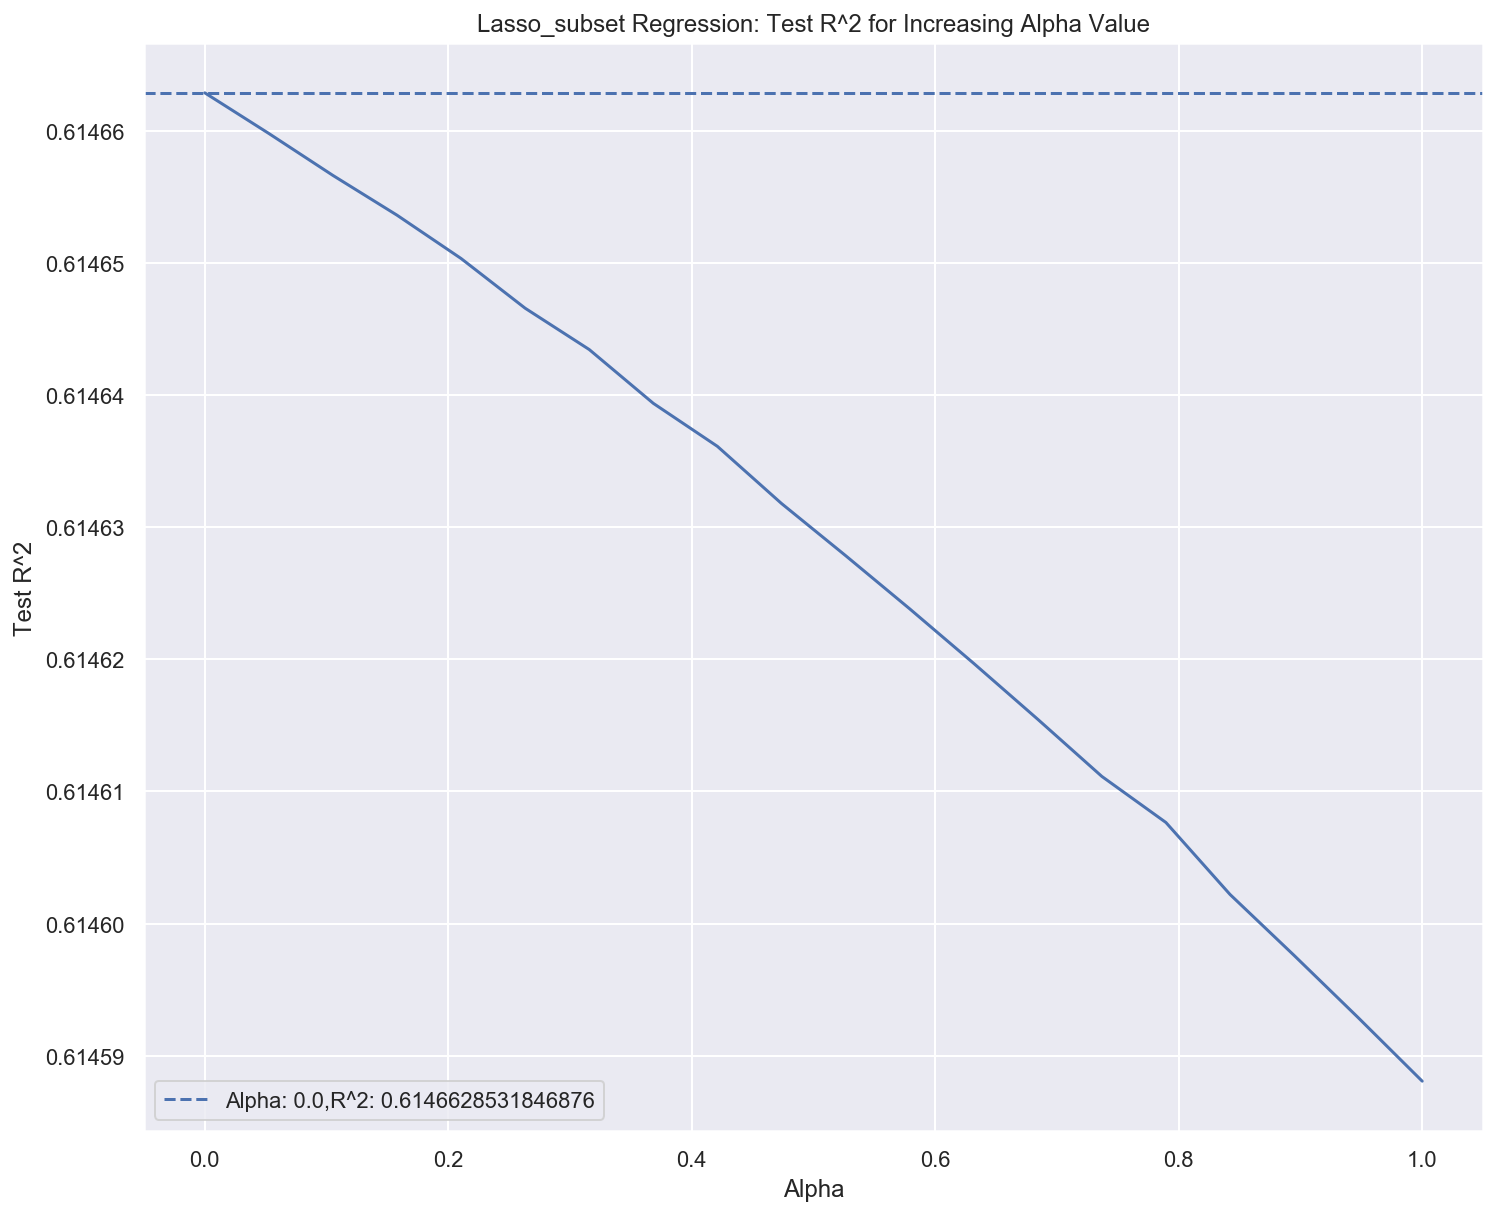

In [94]:
optimal_alpha(0,1,20,Lasso,'Lasso_subset',X_recursive,Y)

It turns out that when we run a lasso regression using our subset of 118 predictors, our test R^2 has nowhere to go but down. This is encouraging, because it means that all 118 variables in our subset are significant. 

#### Ridge

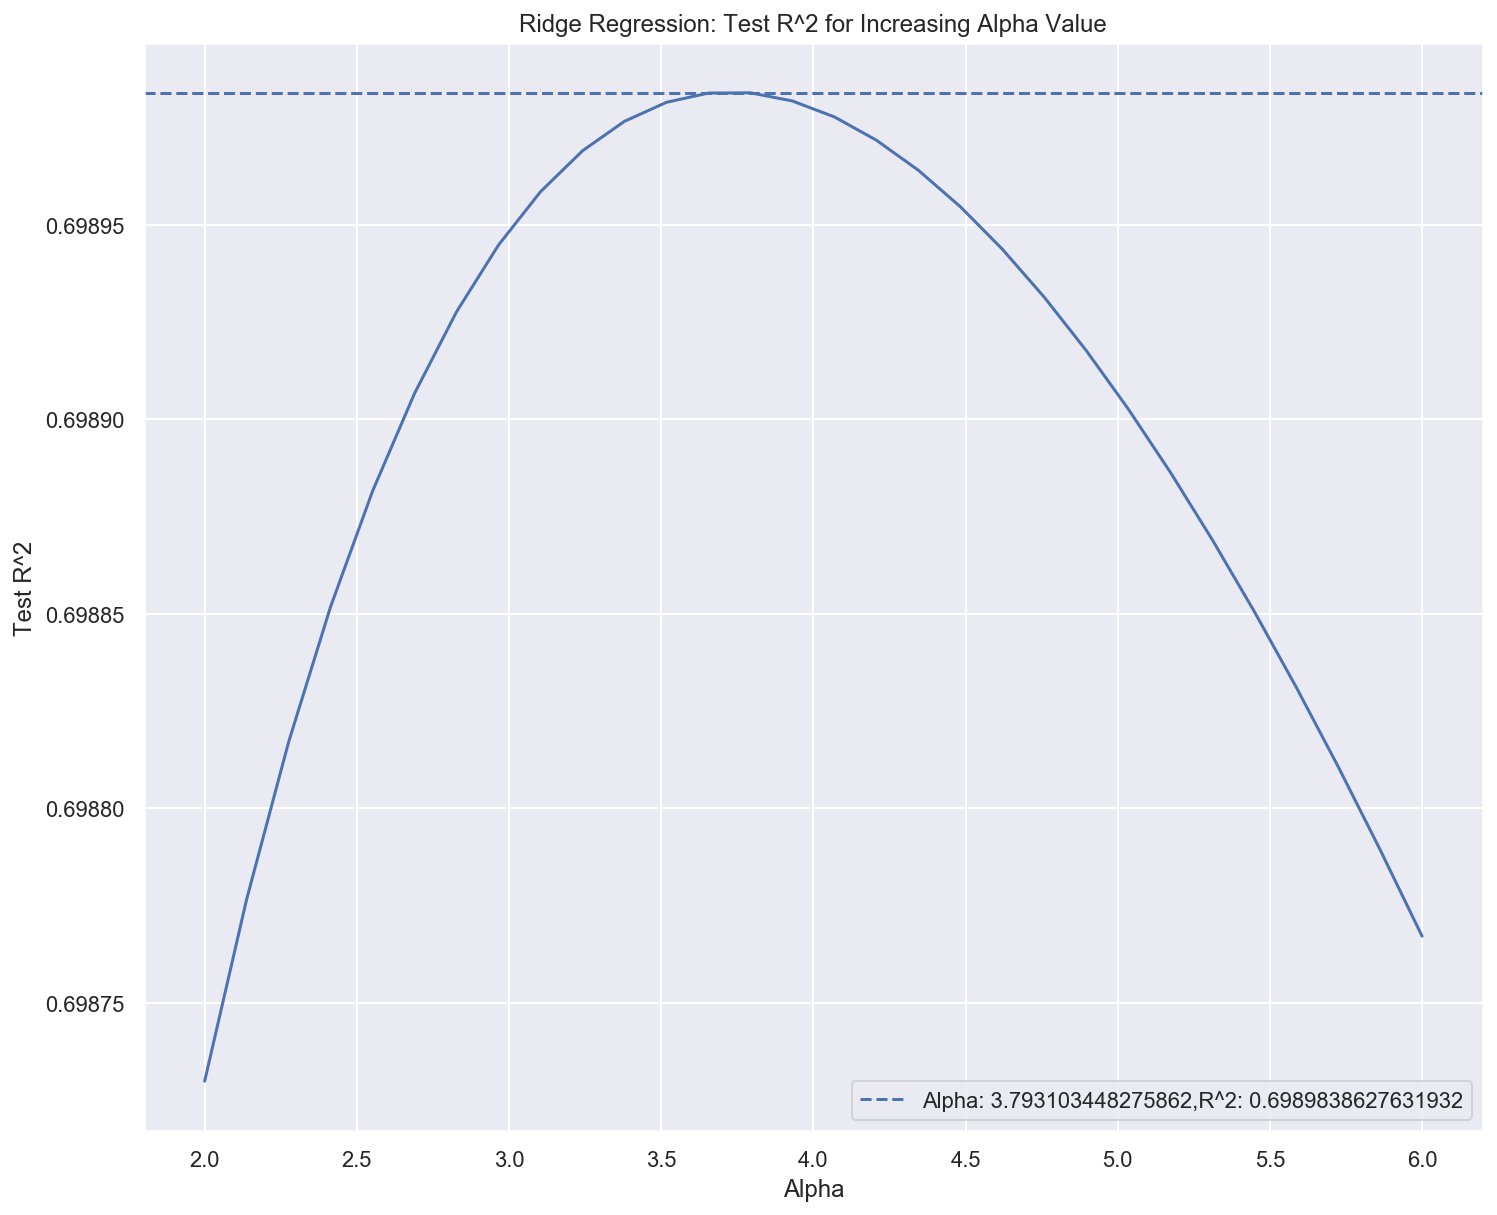

In [96]:
optimal_alpha(2,6,30,Ridge,'Ridge',X,np.log(Y))

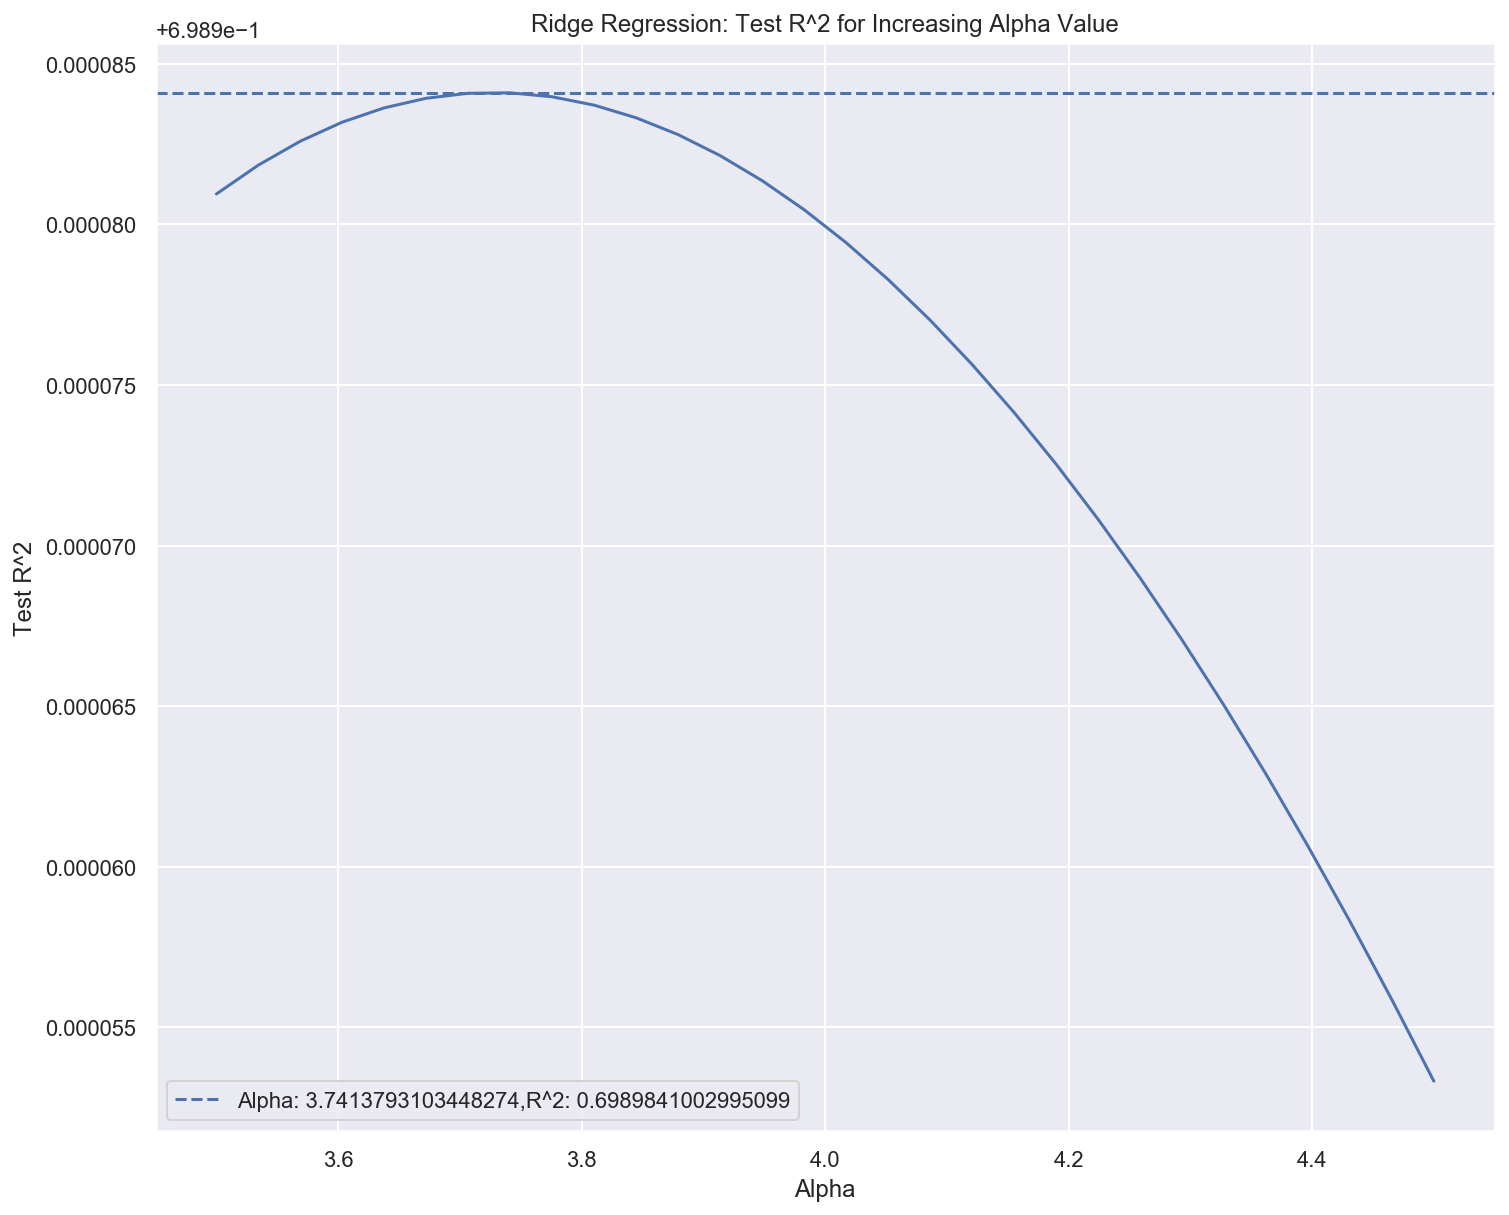

In [98]:
optimal_alpha(3.5,4.5,30,Ridge,'Ridge',X,np.log(Y))

In [99]:
optimal_alphas['Ridge']

3.7413793103448274

In [101]:
ridge_variables,ridge_performance = regularization(X,np.log(Y),optimal_alphas['Ridge'],Ridge)

In [102]:
ridge_performance

{'Train': 0.715636485337833, 'Test': 0.6989841002995099}

Ridge regression did pretty well! Let's do it again with only our 118 subset. 

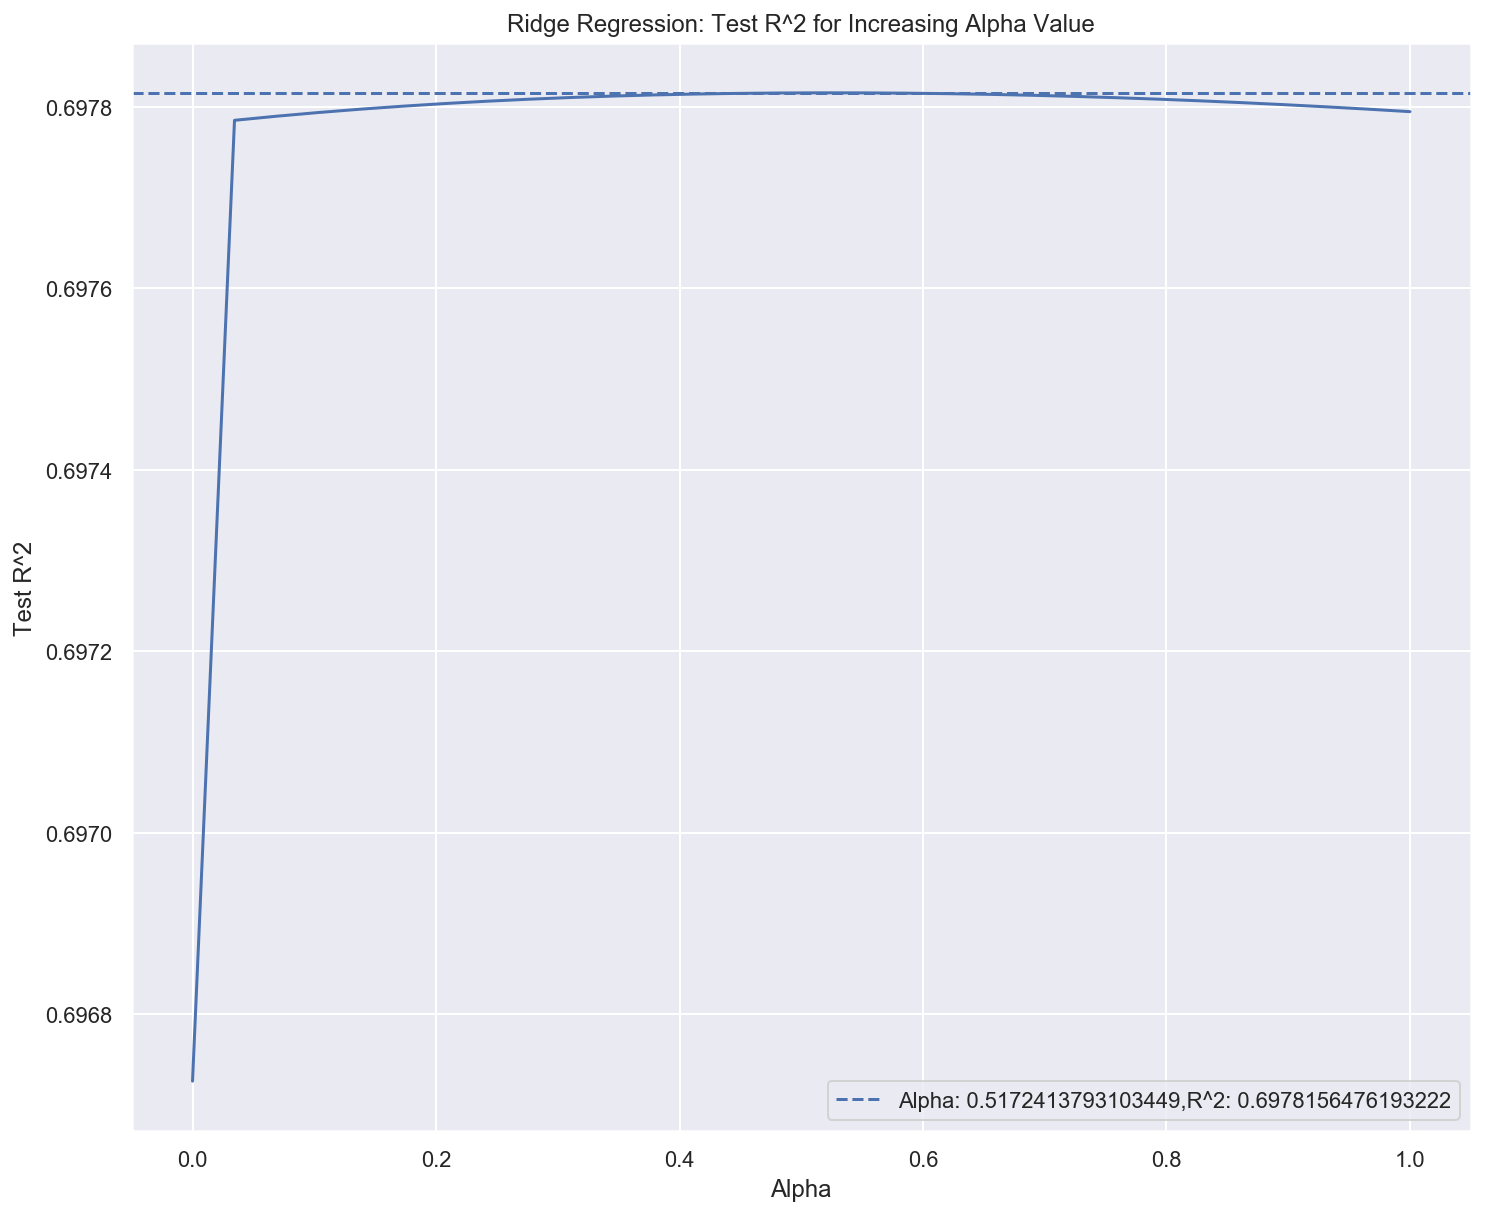

In [107]:
optimal_alpha(0,1,30,Ridge,'Ridge',X_recursive,np.log(Y))

In [108]:
optimal_alphas

{'Lasso': 4.189655172413793, 'Lasso_subset': 0.0, 'Ridge': 0.5172413793103449}

In [109]:
ridge_variables,ridge_performance = regularization(X_recursive,np.log(Y),optimal_alphas['Ridge'],Ridge)

In [110]:
ridge_performance

{'Train': 0.7041792795607064, 'Test': 0.6978156476193222}

Interestingly, it seemed to do slightly worse. Not sure why

In [112]:
ols_variables,ols_performance = regularization(X_recursive,np.log(Y),None,LinearRegression)

In [113]:
ols_performance

{'Train': 0.7042765620381146, 'Test': 0.6977807429554408}

When we us the orignal predictors that we had before elimating many of them with our recursive function, the R^2 for our test data is negative, showing that our initial OLS was drastically overfitting the data.

In [115]:
ols_overfit_variables, ols_overfit_performance = regularization(X,np.log(Y),None,LinearRegression)

In [116]:
ols_overfit_performance

{'Train': 0.7177381839134913, 'Test': -2.1307037053513584e+16}